In [1]:
using DifferentialEquations, Plots #CSV, Tables, Dates, DataFrames, DiffEqSensitivity, JLD2,
cd("C:\\Users\\bsms9jt3\\OneDrive - University of Brighton\\Documents\\Julia\\BCR_inoue_2016\\CSV2Julia_BCRwithA20\\")
### set up where CSV2Julia is
locationOfCSV2Julia="csv2model.py"
reactionsFile="reactions.csv"
parametersFile="parameters_k1_numbers.csv"
rateLawsFile="rateLaws.csv"
scan="scan"
#build a command to execute csv2julia
location=[locationOfCSV2Julia]
thisModelName="odeFileGenerated.jl"
arguments=[reactionsFile, parametersFile, rateLawsFile,thisModelName,scan]
cmd=`python3 $locationOfCSV2Julia $arguments`
run(cmd)
include("C:\\Users\\bsms9jt3\\OneDrive - University of Brighton\\Documents\\Julia\\BCR_inoue_2016\\CSV2Julia_BCRwithA20\\scanIncludes.jl");
include("C:\\Users\\bsms9jt3\\OneDrive - University of Brighton\\Documents\\Julia\\BCR_inoue_2016\\CSV2Julia_BCRwithA20\\variableNames.jl");
###

scan
Running CSV2JuliaDiffEq with parameters left as a function call to paramFun(n), for all params. We will also create a paramFun.jl file that should be included and defines all parameters. If this is incorrect, please re-run with 5th argument set to 'inline'
Opening rateLaws.csv as rate law file
Opening parameters_k1_numbers.csv as parameters file
Opening reactions.csv as reactions file
parameters can now be modified by name.
example to modify k_binding 1.5 fold higher:
modify["k_binding"]=1.5


In [2]:
#####
order=["B", "M", "BM", "C", "CB", "CM", "Cp", "CpB", "CpM", "CBM", "CpBM", "TAK1", "TAK1C", "TAK1p", "TAK1pC", "IKK", "IKKC", "IKKp", "IKKpC", "IKKppC", "IKKpp", "IKKi", "A20"]
function reorderModel(InputFileName,OutputFileName,symsNew)
    # this function takes an input model and and output file name and reorders the species into the order listed in symsNew
    # useful when comparing models that have ended up in a different order

    outputArray=["#file edited by reorderModel.jl to reorder the model species.\n"]
    #go through input file and save each line to an output array
    #only change the line that starts with the index we're looking for
    numberOfSpecies=length(symsNew)

    speciesEquationDict=Dict()
    nextLineSpecies=""
    functionDefinitionReached=false
    #lets go through the file line by line
    open(InputFileName) do f
        for i in enumerate(eachline(f))
            #this line's contents
            thisLine=i[2]

            if !functionDefinitionReached
                push!(outputArray,thisLine)
                functionDefinitionReached=startswith(strip(thisLine),"function")
                continue
            end
            #this will get the contents of the line if it's an equation or variable definition
            thisLineSplit=split(strip(thisLine),"=")
            #this will get the contents of the line if it's a code comment
            commentLine=split(strip(thisLine),"#")

            #lets check if this is a comment line where the only contents are one of the symbols
            if((length(commentLine)>1)&& (commentLine[2] in symsNew))
                #if we've found a species comment before an equation just make a note of the species so know what the next line represents
                nextLineSpecies=commentLine[2]
                continue
            end
            #if we set next line species on the previous iteration this line is an equation for that species, so save it to the dictionary
            if !isempty(nextLineSpecies)
                speciesEquationDict[nextLineSpecies]=thisLineSplit[2]
                nextLineSpecies=""
                continue
            end
        end

    end
    #loop through all the variable definitions and put them in the right order
    for thisSymEnum in enumerate(symsNew)
        thisSymIndex=thisSymEnum[1]
        thisSymName=thisSymEnum[2]
        #cMyct=maximum([y[1],0])
        thisLine="\t"*thisSymName*"=maximum([y["*string(thisSymIndex)*"],0])"
        push!(outputArray,thisLine)
    end

    #loop through all the equations and put them in the right order
    for thisSymEnum in enumerate(symsNew)
        thisSymIndex=thisSymEnum[1]
        thisSymName=thisSymEnum[2]
        #	#cMyct
        #   dy[1]= + 1.0
        commentLine="\t#"*thisSymName
        push!(outputArray,commentLine)
        thisLine="\tdy["*string(thisSymIndex)*"]="*speciesEquationDict[thisSymName]
        push!(outputArray,thisLine)
    end

    push!(outputArray,"end")

    #now write the output array to the output file
    open(OutputFileName,"w") do f
        for line in outputArray
            write(f, line*"\n")
        end

    end
    println("ODE file reordered, make sure to refer to the new species name array, that was used as input to this function, when fixing species, plotting etc")
end
reorderModel("C:\\Users\\bsms9jt3\\OneDrive - University of Brighton\\Documents\\Julia\\BCR_inoue_2016\\CSV2Julia_BCRwithA20\\odeFileGenerated.jl", "C:\\Users\\bsms9jt3\\OneDrive - University of Brighton\\Documents\\Julia\\BCR_inoue_2016\\CSV2Julia_BCRwithA20\\odeFileGenerated.jl", order)
include("C:\\Users\\bsms9jt3\\OneDrive - University of Brighton\\Documents\\Julia\\BCR_inoue_2016\\CSV2Julia_BCRwithA20\\odeFileGenerated.jl")
#####


ODE file reordered, make sure to refer to the new species name array, that was used as input to this function, when fixing species, plotting etc


odeFile (generic function with 1 method)

In [3]:

function originalsignal(t)
    global PHASE
    global DOSE
    if PHASE == 1
        sinput=1.0;
        slate=0.05;
        sbase=0.0;
        tpulse=0.25;
        traise=0.5;
        tdecay=0.5;
        tdelay=0;
    else
        sinput = 1.0 - (1.0)*DOSE;
        #sbase = 0.01; #commented in original
        tpulse = 0.25;
        traise = 0.5;
        tdecay = 0.5;
        tdelay = 0;
        #slate = 0.05 - (0.05 - 0.01)*DOSE; #this line would make slate=0.01*DOSE. Commented in original
        sbase=0.0;
        slate=0.05 - (0.05)*DOSE;
    end

    signal=sbase;

    if t <= tdelay || PHASE==1
        signal = sbase;
    elseif tdelay < t && t <= (traise + tdelay)
        signal = (t - tdelay)*(sinput - sbase)/traise + sbase;
    elseif (traise + tdelay) < t && t <= (tpulse + traise + tdelay)
        signal = sinput;
    elseif (tpulse + traise + tdelay) < t
        signal = (sinput - slate)*exp(-(t - tpulse - traise - tdelay)/tdecay) + slate;
    end
    return signal
end
#function to quickly make mutants. Two phenotypes, fullmut (24params) or 8hyp
function card11mut(modify,mutantstrengthfactor,phenotype="fullmut")
    msf=mutantstrengthfactor
    if phenotype=="fullmut"
        mods=[msf,1/msf,msf,1/msf,msf,1/msf,msf,1/msf,msf,1/msf,msf,1/msf,msf,1/msf,msf,1/msf,msf,msf,msf,msf,1/msf,1/msf,1/msf,1/msf]
    elseif phenotype=="8hyp"
        mods=a=[1,1,1,1,1,1,1,1,1,1,msf,1,msf,1/msf,msf,1/msf,1,msf,1,msf,1,1,1,1/msf]#8hyp_mut
    end
    #Would lke to model mutations F123I and L225LI in the CARD11 domain.
    #Activating mutations!!
    #Cp dependent TAK1 phosphorylation, flux36
    modify["k1_CTpS"]=mods[1] #kCTpS
    modify["k2_kmCTpS"]=mods[2] #kmCTpS
    #CpB dependent TAK1 phosphorylation, flux37
    modify["k1_CBTpS"]=mods[3] #kCBTpS
    modify["k2_kmCBTpS"]=mods[4] #kmCBTpS
    #CpM dependent TAK1 phosphorylation, flux38
    modify["k1_CMTpS"]=mods[5] #kCMTpS
    modify["k2_kmCMTpS"]=mods[6] #kmCMTpS
    #CpBM dependent TAK1 phosphorylation, flux39
    modify["k1_CBMTpS"]=mods[7] #kCBMTpS
    modify["k2_kmCBMTpS"]=mods[8] #kmCBMTpS
    ##
    #Cp dependent TAK1C phosphorylation, flux43
    modify["k1_CTpCS"]=mods[9] #kCTpCS
    modify["k2_kmCTpCS"]=mods[10] #kmCTpCS
    #CpB dependent TAK1C phosphorylation, flux44
    modify["k1_CBTpCS"]=mods[11] #kCBTpCS
    modify["k2_kmCBTpCS"]=mods[12] #kmCBTpCS
    #CpM dependent TAK1C phosphorylation, flux45
    modify["k1_CMTpCS"]=mods[13] #kCMTpCS
    modify["k2_kmCMTpCS"]=mods[14] #kmCMTpCS
    #CpBM dependent TAK1C phosphorylation, flux46
    modify["k1_CBMTpCS"]=mods[15] #kCBMTpCS
    modify["k2_kmCBMTpCS"]=mods[16] #kmCBMTpCS
    ##
    #CARD11 activating mutations (F123I, L225LI) in the LATCH domain increase affinity for BCL10
    #Cp association to BCL10, flux17
    modify["k1_CpaB"]=mods[17] #kCpaB
    #C association to B, flux15
    modify["k1_CaB"]=mods[18] #kCaB
    #CM association to B, flux27
    modify["k1_CMaB"]=mods[19] #kCMaB
    #CpM association to B, flux29
    modify["k1_CpMaB"]=mods[20] #kCpMaB
    ##decreasing dissociation between Bcl10 and Card11mut (may not be needed)
    #CpB dissociation  flux18
    modify["k1_CpdB"]=mods[21] #kCpdB
    #CB dissociation flux16
    modify["k1_CdB"]=mods[22] #kCdB
    #CBM dissociation flux28
    modify["k1_CMdB"]=mods[23] #kCMdB
    #CpBM dissociation flux30
    modify["k1_CpMdB"]=mods[24] #kCpMdB
    return modify
end
function displaymodifiers(modify)
print(modify["k1_CTpS"]," ",modify["k2_kmCTpS"]," ",modify["k1_CBTpS"]," ",modify["k2_kmCBTpS"]," ",modify["k1_CMTpS"]," ",modify["k2_kmCMTpS"]," ",modify["k1_CBTpCS"]," ",modify["k2_kmCBTpCS"]," ",modify["k1_CTpCS"]," ",modify["k2_kmCTpCS"]," ",modify["k1_CBTpCS"]," ",modify["k2_kmCBTpCS"]," ",modify["k1_CMTpCS"]," ",modify["k2_kmCMTpCS"]," ",modify["k1_CBMTpCS"]," ",modify["k2_kmCBMTpCS"]," ",modify["k1_CpaB"]," ",modify["k1_CaB"]," ",modify["k1_CMaB"]," ",modify["k1_CpMaB"]," ",modify["k1_CpdB"]," ",modify["k1_CdB"]," ",modify["k1_CMdB"]," ",modify["k1_CpMdB"])
end

displaymodifiers (generic function with 1 method)

In [9]:

card11mut(modify,2)
displaymodifiers(modify)
tspan=[0.0,360.0]
sollist=[]
###
sollist=[]
for k_A20induction in [0.001,0.005,0.01,0.02]
	modify["k1_A20linearinduction"]=k_A20induction
#     uequilibrium_inoue=[0.698, 0.717, 0.093, 0.658, 0.152, 0.133, 9.237e-6, 1.849e-5, 1.367e-5, 0.057, 5.7677e-5, 0.731, 0.130, 0.113, 0.026, 0.719, 0.231, 0.009, 0.042, 2.625e-8, 2.000e-6, 4.076e-8,0,1]
    uequilibrium_inoue=ones(23)*0.3
	PHASE=1
    phase1_tspan=[0.0,1000.0]
	prob_phase1_inoue=ODEProblem(odeFile,uequilibrium_inoue,phase1_tspan,originalsignal,maxiters=1e6)
	phase1_sol=solve(prob_phase1_inoue)
	u0_endofphase1=float(phase1_sol[end])
	##define problem
	global PHASE=2
	global DOSE=0
	prob_inoue=ODEProblem(odeFile,u0_endofphase1,tspan,originalsignal) #nb pre stim graph included on exploration_BCR, better plot!
	sol=solve(prob_inoue)
	push!(sollist, sol)
end
###


2.0 0.5 2.0 0.5 2.0 0.5 2.0 0.5 2.0 0.5 2.0 0.5 2.0 0.5 2.0 0.5 2.0 2.0 2.0 2.0 0.5 0.5 0.5 0.5

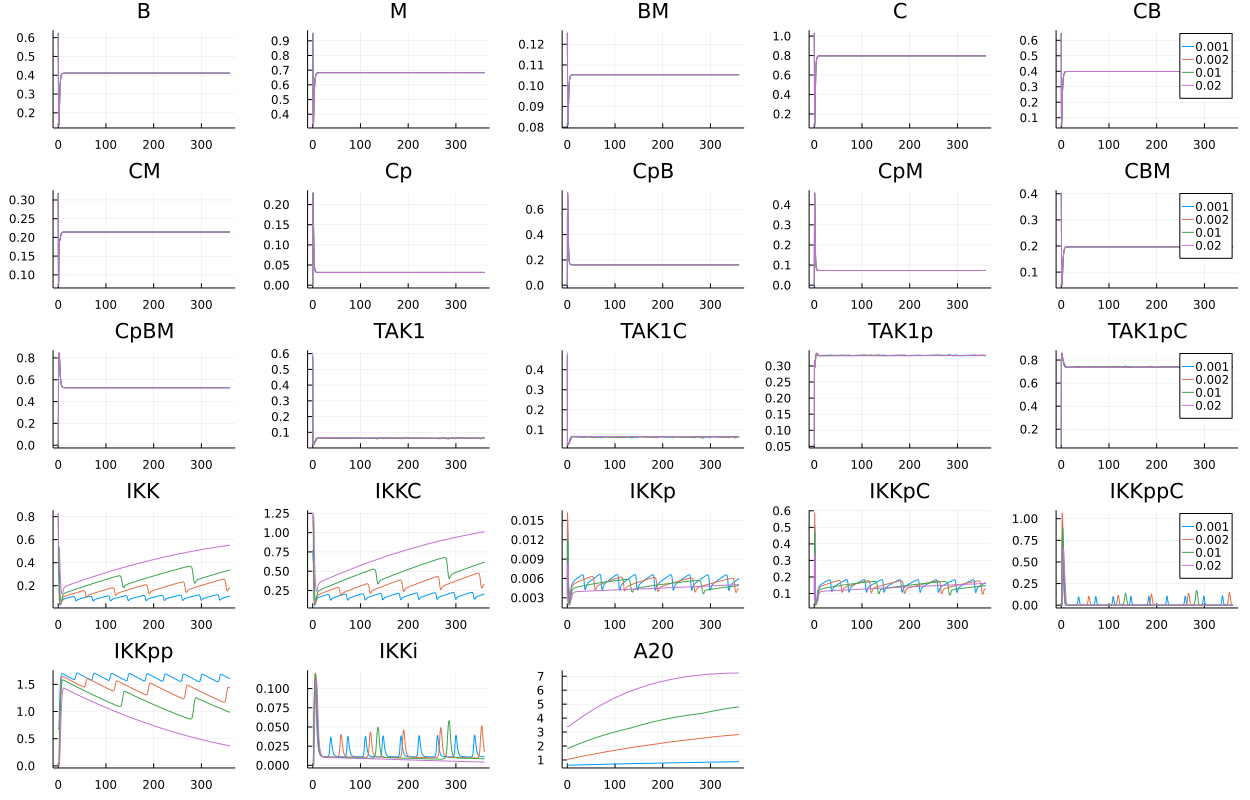

In [12]:
syms=order
labelname=[0.001, 0.002, 0.01, 0.02]
plot_array = Any[]
for i in 1:length(syms)
    plotVar=plot()
    for j in 1:length(sollist)
        plot!(plotVar,sollist[j].t,sollist[j][i,:],label=labelname[j])
    end
    push!(plot_array,plotVar) # make a plot and add it to the plot_array
end
titleArray=reshape(syms, 1, length(syms))
plot(plot_array...,layout=length(plot_array),title=titleArray)
plot!(size=[1250,800],legend=[:none :none :none :none :topright])

In [11]:
length(sollist)

4